In [ ]:
cat_set = "/content/cat"
dog_set = "/content/dog"

In [7]:
import os
import pandas as pd
import numpy as np

# List the files in the directories
img_cat = [os.path.join(cat_set, file) for file in os.listdir(cat_set)[:1000]]
img_dog = [os.path.join(dog_set, file) for file in os.listdir(dog_set)[:1000]]

cat_df = pd.DataFrame({"image_path": img_cat, "Target": 1})
dog_df = pd.DataFrame({"image_path": img_dog, "Target": 0})
print(len(cat_df), len(dog_df))

1000 1000


In [8]:
# Concatenate the dataframes
cat_dog_df = pd.concat([cat_df, dog_df], ignore_index=True)

# Shuffle the combined dataframes
cat_dog_df = cat_dog_df.sample(frac=1).reset_index(drop=True)
cat_dog_df.head()

,image_path,Target
0,/content/dog/549.jpg,0
1,/content/dog/465.jpg,0
2,/content/cat/130.jpg,1
3,/content/dog/368.jpg,0
4,/content/cat/601.jpg,1


In [10]:
from skimage.feature import hog
from skimage import io, color, transform, exposure
import numpy as np
import matplotlib.pyplot as plt
import cv2


def hsv_hog_features(img_path, resize_dim=(160, 160), pixels_per_cell=(8, 8), cells_per_block=(1, 1)):
    try:
        # Read the image
        image = io.imread(img_path)

        # Resize the image
        img_resized = transform.resize(image, resize_dim, anti_aliasing=True)

        # Convert the image to HSV
        image_hsv = color.rgb2hsv(img_resized)

        # Separate the HSV channels
        hue_channel = image_hsv[:, :, 0]
        saturation_channel = image_hsv[:, :, 1]
        value_channel = image_hsv[:, :, 2]

        orientations = 9

        hog_features = hog(value_channel,
                          orientations=orientations,
                          pixels_per_cell=pixels_per_cell,
                          cells_per_block=cells_per_block,
                          block_norm='L2-Hys',
                          visualize=False)

        return hue_channel, saturation_channel, hog_features

    except Exception as e:
        print(f"Error in image {img_path}: {str(e)}")
        return None, None, None


In [37]:
# Define a function to calculate the features and assign them to the corresponding columns
def calculate_features(img_path):
    if img_path is not None:
        hue_features, sat_features, hog_features = hsv_hog_features(img_path)
        return hue_features, sat_features, hog_features
    else:
        return None, None, None

# Apply the function to each row of 'image_path' and assign the results to the corresponding columns
cat_dog_df['hue_features'], cat_dog_df['sat_features'], cat_dog_df['hog_features'] = zip(*cat_dog_df['image_path'].apply(calculate_features))

In [38]:
cat_dog_df.dropna(inplace=True)

In [39]:
hue_features = np.array([np.histogram(image, bins=20)[0] for image in cat_dog_df['hue_features']])
sat_features = np.array([np.histogram(image, bins=20)[0] for image in cat_dog_df['sat_features']])
hog_features = np.array(cat_dog_df['hog_features'].tolist())

hue_features.shape, sat_features.shape, hog_features.shape

((1999, 20), (1999, 20), (1999, 3600))

In [40]:
X = np.hstack((hue_features, sat_features, hog_features))
y = cat_dog_df["Target"]

# Reshape X to a 2D array
X = X.reshape(X.shape[0], -1)

# Display the shape of X and y
print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (1999, 3640)
y shape: (1999,)


In [41]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("X training:", X_train.shape)
print("X test:", X_test.shape)
print("y training:", y_train.shape)
print("y test:", y_test.shape)

X training: (1599, 3640)
X test: (400, 3640)
y training: (1599,)
y test: (400,)


In [42]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
from skimage.filters import prewitt_h, prewitt_v
from skimage.morphology import closing, square
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

# Perform best dimensional reduction PCA
def best_pca(X):
    pca = PCA()
    X_pca = pca.fit_transform(X)

    # Calculate explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_

    # Plot explained variance ratio
    plt.figure(figsize=(10, 6))
    plt.plot(np.cumsum(explained_variance_ratio), marker='o', linestyle='-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Explained Variance Ratio vs. Number of Components')
    plt.grid(True)
    plt.show()
    return

#perform best SVC
def best_svc(n_components, X_train, X_test, y_train, y_test):
    # Define the pipeline with a scaler, PCA, and SVC
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('pca', PCA(n_components)),
        ('svc', SVC())
    ])

    # Define the parameter grid
    param_grid = {
        'svc__C': [0.1, 1, 10, 100, 1000],  # Values for C
        'svc__gamma': [0.001, 0.01, 0.1, 1, 10]  # Values for gamma
    }

    # Perform grid search
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1)
    grid_search.fit(X_train, y_train)

    # Print the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Evaluate the model on the test set
    accuracy = grid_search.score(X_test, y_test)
    print("Test Accuracy:", accuracy)
    return


#perform best Random Forest
def best_rf(X_train, X_test, y_train, y_test):
    # Define the parameter grid
    param_grid = {
            'n_estimators': [100, 250, 500],
            'max_depth': [None, 5, 10, 20],
            'criterion': ['gini', 'entropy']
            }

    # Instantiate the Random Forest classifier
    rf_classifier = RandomForestClassifier()

    # Instantiate GridSearchCV
    grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Perform grid search
    grid_search.fit(X_train, y_train)

    # Print the best parameters and best score
    print("Best Parameters:", grid_search.best_params_)
    print("Best Score:", grid_search.best_score_)

    # Evaluate the model on the test set
    accuracy = grid_search.score(X_test, y_test)
    print("Test Accuracy:", accuracy)
    return



#perform best KNN
def best_knn(n_components, X_train, X_test, y_train, y_test):
    # Define the pipeline
    pipe_spm = Pipeline([
        ('scaler', StandardScaler()),  # Feature scaling
        ('pca', PCA(n_components)),  # Dimensionality reduction
        ('knn', KNeighborsClassifier())  # KNN
    ])
    # Define the parameter grid to search
    param_grid = {
    'knn__n_neighbors': [2, 3, 5, 7],  # Number of neighbors for kNN
    'knn__weights': ['uniform', 'distance']  # Weighting method for kNN
    }
    # Setup the grid search with cross-validation
    grid_search = GridSearchCV(pipe_spm, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

    # Perform the grid search on the training data
    grid_search.fit(X_train, y_train)

    # Get the best model
    best_pipeline = grid_search.best_estimator_

    # Print the best parameters found
    print("Best parameters:", grid_search.best_params_)

    # Evaluate the model on the test set
    accuracy = best_pipeline.score(X_test, y_test)
    print("Accuracy on the test set:", accuracy)
    return

In [43]:
ssc = StandardScaler()
X_scaled = ssc.fit_transform(X_train)

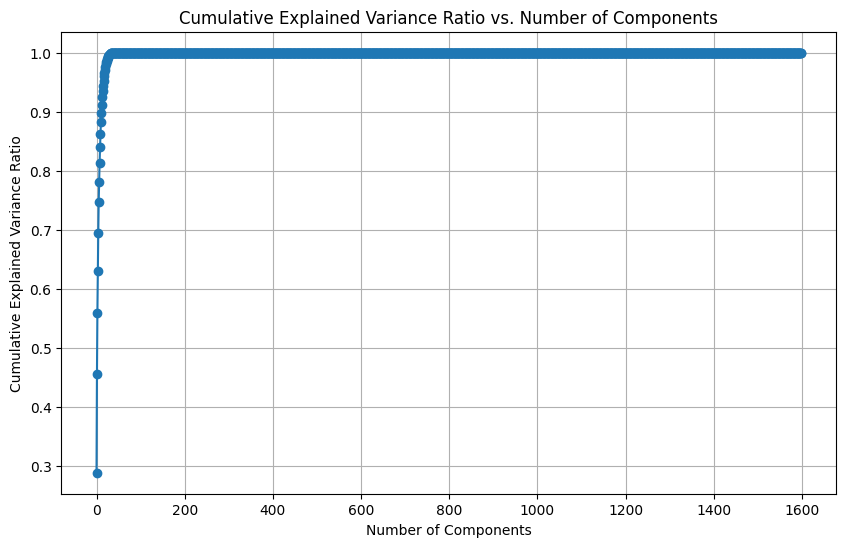

In [45]:
best_pca(X_train)

In [54]:
n_components = 100

In [55]:
best_svc(n_components, X_train, X_test, y_train, y_test)

Best Parameters: {'svc__C': 10, 'svc__gamma': 0.001}
Best Score: 0.7242065047021944
Test Accuracy: 0.745


In [56]:
best_rf(X_train, X_test, y_train, y_test)

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 500}
Best Score: 0.7142006269592477
Test Accuracy: 0.715


In [57]:
best_knn(n_components, X_train, X_test, y_train, y_test)

Best parameters: {'knn__n_neighbors': 7, 'knn__weights': 'uniform'}
Accuracy on the test set: 0.635


In [47]:
# Define base classifiers with preprocessing
pipe_SVC = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),
    ('svc', SVC(C=10.0, gamma=0.001, kernel='rbf'))
])

rf_classifier = RandomForestClassifier(n_estimators=500,
                                       max_depth=20,
                                       criterion='gini')

pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components)),  # Dimensionality reduction
    ('knn', KNeighborsClassifier(n_neighbors=3, weights='distance'))  # KNN
])


In [48]:
from sklearn.model_selection import cross_val_score

# Define the list of classifiers and their corresponding labels
classifiers = [pipe_SVC, pipe_knn, rf_classifier ]
clf_labels = ['SVC', 'kNN', 'Random Forest']

# Perform 10-fold cross-validation for each classifier
for clf, label in zip(classifiers, clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print(f'ROC AUC: {scores.mean():.2f} (+/- {scores.std():.2f}) [{label}]')


ROC AUC: 0.80 (+/- 0.03) [SVC]
ROC AUC: 0.66 (+/- 0.03) [kNN]
ROC AUC: 0.78 (+/- 0.03) [Random Forest]


Majority Voting

In [49]:
from sklearn.ensemble import VotingClassifier


# Create a voting classifier using majority voting
voting_clf = VotingClassifier(
    estimators=[('svc', pipe_SVC), ('rf', rf_classifier), ('knn', pipe_knn)],
    voting='hard'  # Use 'hard' voting for majority voting
)

# Train the voting classifier
voting_clf.fit(X_train, y_train)

# Make predictions
y_pred_voting = voting_clf.predict(X_test)

# Calculate accuracy
accuracy_voting = accuracy_score(y_test, y_pred_voting)
print("Accuracy using majority voting:", accuracy_voting)

Accuracy using majority voting: 0.76


BaggingClassifier

In [50]:
from sklearn.ensemble import BaggingClassifier

# Create bagging classifiers for each base classifier
bagging_SVC = BaggingClassifier(estimator=pipe_SVC, n_estimators=10, random_state=42)
bagging_RF = BaggingClassifier(estimator=rf_classifier, n_estimators=10, random_state=42)
bagging_kNN = BaggingClassifier(estimator=pipe_knn, n_estimators=10, random_state=42)

# Train bagging classifiers
bagging_SVC.fit(X_train, y_train)
bagging_RF.fit(X_train, y_train)
bagging_kNN.fit(X_train, y_train)

# Make predictions
y_pred_SVC = bagging_SVC.predict(X_test)
y_pred_RF = bagging_RF.predict(X_test)
y_pred_kNN = bagging_kNN.predict(X_test)

# Calculate accuracy for each classifier
accuracy_SVC = accuracy_score(y_test, y_pred_SVC)
accuracy_RF = accuracy_score(y_test, y_pred_RF)
accuracy_kNN = accuracy_score(y_test, y_pred_kNN)

print("Accuracy for SVC Bagging:", accuracy_SVC)
print("Accuracy for RF Bagging:", accuracy_RF)
print("Accuracy for kNN Bagging:", accuracy_kNN)

Accuracy for SVC Bagging: 0.7575
Accuracy for RF Bagging: 0.7475
Accuracy for kNN Bagging: 0.6425


Applying Gradient Boosting Classifier

In [51]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier


# Define the meta-classifier (Gradient Boosting Machine)
gbm = GradientBoostingClassifier()

# Create the stacking ensemble
estimators = [('svc', pipe_SVC), ('rf', rf_classifier), ('knn', pipe_knn)]
stacking_clf = StackingClassifier(estimators=estimators, final_estimator=gbm)

# Train the stacking classifier
stacking_clf.fit(X_train, y_train)

# Make predictions
y_pred = stacking_clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7475


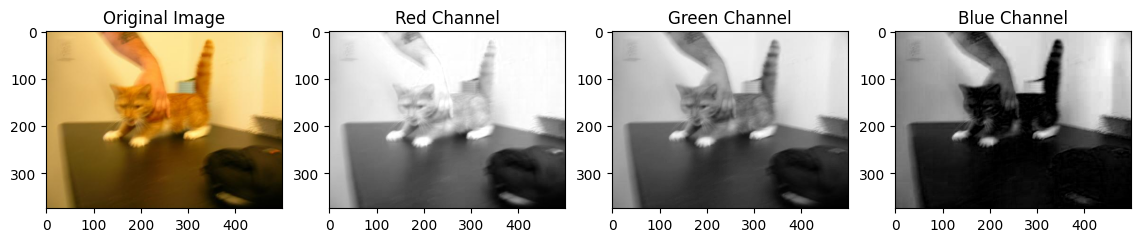

Shape of the HOG feature vector: (397062,)


In [63]:
from skimage.feature import hog
from skimage import io, color
import numpy as np
import matplotlib.pyplot as plt

# Load a color image
image = io.imread('/content/cat/0.jpg')

# Split the image into color channels
red_channel = image[:, :, 0]
green_channel = image[:, :, 1]
blue_channel = image[:, :, 2]

# Show the results
fig, axes = plt.subplots(1, 4, figsize=(14, 5))

axes[0].imshow(image)
axes[0].set_title('Original Image')

axes[1].imshow(red_channel, cmap='gray')
axes[1].set_title('Red Channel')

axes[2].imshow(green_channel, cmap='gray')
axes[2].set_title('Green Channel')

axes[3].imshow(blue_channel, cmap='gray')
axes[3].set_title('Blue Channel')

plt.show()

# Print the shape of the HOG feature vector
print("Shape of the HOG feature vector:", hog_features.shape)

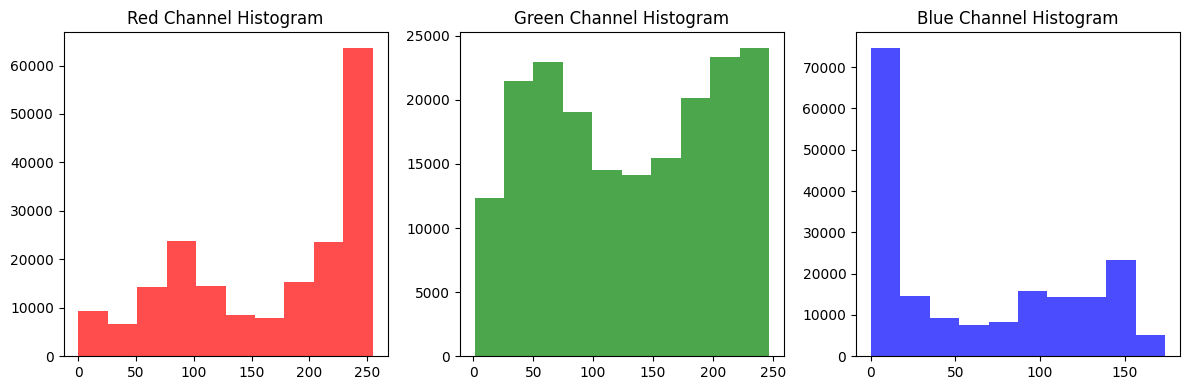

In [67]:
# Plot histograms for each channel with 10 bins
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(red_channel.ravel(), bins=10, color='red', alpha=0.7)
axes[0].set_title('Red Channel Histogram')

axes[1].hist(green_channel.ravel(), bins=10, color='green', alpha=0.7)
axes[1].set_title('Green Channel Histogram')

axes[2].hist(blue_channel.ravel(), bins=10, color='blue', alpha=0.7)
axes[2].set_title('Blue Channel Histogram')

plt.tight_layout()
plt.show()

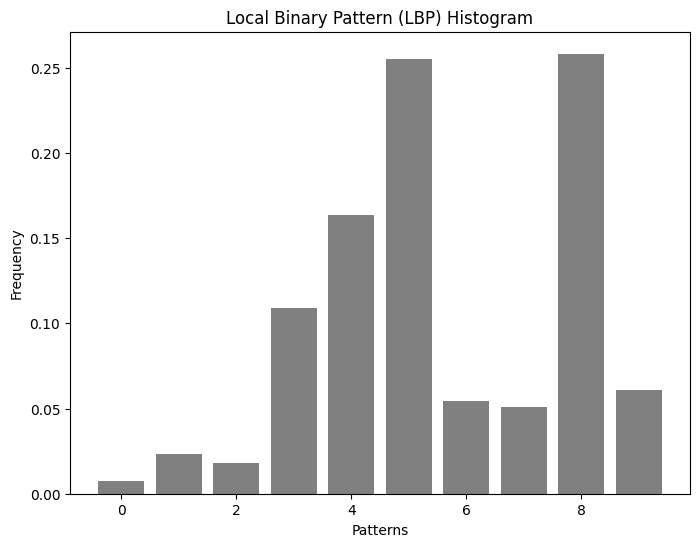

In [68]:
from skimage.feature import local_binary_pattern
from skimage import io, color
import numpy as np
import matplotlib.pyplot as plt

# Load a color image
image = io.imread('/content/cat/0.jpg')

# Convert the image to grayscale
gray_image = color.rgb2gray(image)

# Compute Local Binary Pattern (LBP)
radius = 1
n_points = 8 * radius
lbp = local_binary_pattern(gray_image, n_points, radius, method='uniform')

# Compute the histogram of the LBP image
hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

# Normalize the histogram
hist = hist.astype("float")
hist /= (hist.sum() + 1e-7)

# Plot the histogram
plt.figure(figsize=(8, 6))
plt.bar(np.arange(0, len(hist)), hist, width=0.8, color='gray')
plt.title('Local Binary Pattern (LBP) Histogram')
plt.xlabel('Patterns')
plt.ylabel('Frequency')
plt.show()


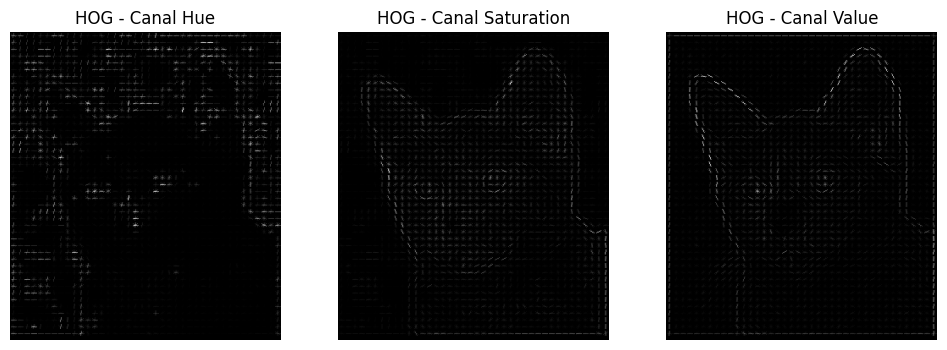

In [ ]:
from skimage.feature import hog
from skimage import io, color, exposure
import numpy as np
import matplotlib.pyplot as plt

# Load a color image
image = io.imread('/content/cat/176.jpg')

# Convert the image to HSV
image_hsv = color.rgb2hsv(image)

# Split the HSV image into its components (Hue, Saturation, Value)
hue_channel = image_hsv[:, :, 0]
saturation_channel = image_hsv[:, :, 1]
value_channel = image_hsv[:, :, 2]

# Parameters for HOG
orientations = 9
pixels_per_cell = (8, 8)
cells_per_block = (2, 2)

# Compute HOG for each component of the HSV color space
hog_hue, hog_hue_image = hog(hue_channel, orientations=orientations, pixels_per_cell=pixels_per_cell,
                              cells_per_block=cells_per_block, block_norm='L2-Hys', visualize=True)
hog_saturation, hog_saturation_image = hog(saturation_channel, orientations=orientations, pixels_per_cell=pixels_per_cell,
                                          cells_per_block=cells_per_block, block_norm='L2-Hys', visualize=True)
hog_value, hog_value_image = hog(value_channel, orientations=orientations, pixels_per_cell=pixels_per_cell,
                                  cells_per_block=cells_per_block, block_norm='L2-Hys', visualize=True)

# Show the HOG images for each component of the HSV color space
fig, axes = plt.subplots(1, 3, figsize=(12, 4), sharex=True, sharey=True)

axes[0].imshow(hog_hue_image, cmap=plt.cm.gray)
axes[0].set_title('HOG - Hue Channel')
axes[0].axis('off')

axes[1].imshow(hog_saturation_image, cmap=plt.cm.gray)
axes[1].set_title('HOG - Saturation Channel')
axes[1].axis('off')

axes[2].imshow(hog_value_image, cmap=plt.cm.gray)
axes[2].set_title('HOG - Value Channel')
axes[2].axis('off')

plt.show()



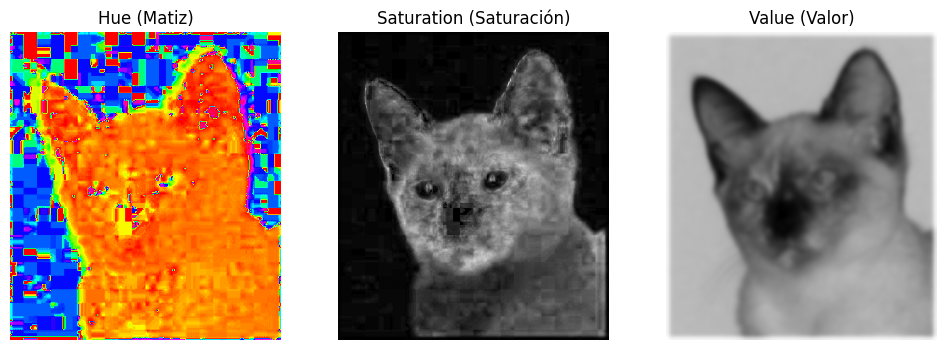

In [ ]:
from skimage import io, color
import matplotlib.pyplot as plt
import cv2

# Load a color image
image = io.imread('/content/cat/176.jpg')

# Convert the image to HSV
image_hsv = color.rgb2hsv(image)

# Split the HSV image into its components (Hue, Saturation, Value)
hue_channel = image_hsv[:, :, 0]
saturation_channel = image_hsv[:, :, 1]
value_channel = cv2.GaussianBlur(image_hsv[:, :, 2], (15, 15), 0)

# Show the three channels of the HSV color space
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].imshow(hue_channel, cmap='hsv')
axes[0].set_title('Hue')
axes[0].axis('off')

axes[1].imshow(saturation_channel, cmap='gray')
axes[1].set_title('Saturation')
axes[1].axis('off')

axes[2].imshow(value_channel, cmap='gray')
axes[2].set_title('Value')
axes[2].axis('off')

plt.show()


In [ ]:
value_channel.shape

(364, 320)

In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical


# Load and preprocess images
def load_and_preprocess_image(image_path, target_size=(100, 100)):
    image = load_img(image_path, target_size=target_size)
    image_array = img_to_array(image) / 255.0  # Normalizing pixel values
    return image_array

# Use list comprehension to load and preprocess images
X = np.array([load_and_preprocess_image(img_path) for img_path in cat_dog_df['image_path']])

# Convert target labels to categorical
y = cat_dog_df["Target"]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Display shapes of the datasets
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (1600, 100, 100, 3)
Shape of y_train: (1600,)
Shape of X_test: (400, 100, 100, 3)
Shape of y_test: (400,)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers

#CNN
model = keras.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(10, activation='softmax')
])

In [ ]:
# model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# train model
model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))


Epoch 1/20
25/25 [==============================] - 31s 1s/step - loss: 0.8830 - accuracy: 0.5056 - val_loss: 0.7036 - val_accuracy: 0.4800
Epoch 2/20
25/25 [==============================] - 29s 1s/step - loss: 0.6836 - accuracy: 0.5619 - val_loss: 0.6694 - val_accuracy: 0.6050
Epoch 3/20
25/25 [==============================] - 30s 1s/step - loss: 0.6672 - accuracy: 0.5969 - val_loss: 0.6633 - val_accuracy: 0.6225
Epoch 4/20
25/25 [==============================] - 30s 1s/step - loss: 0.6082 - accuracy: 0.6612 - val_loss: 0.6102 - val_accuracy: 0.6900
Epoch 5/20
25/25 [==============================] - 30s 1s/step - loss: 0.5432 - accuracy: 0.7163 - val_loss: 0.6518 - val_accuracy: 0.6375
Epoch 6/20
25/25 [==============================] - 30s 1s/step - loss: 0.4789 - accuracy: 0.7644 - val_loss: 0.6016 - val_accuracy: 0.7125
Epoch 7/20
25/25 [==============================] - 30s 1s/step - loss: 0.4147 - accuracy: 0.7987 - val_loss: 0.6222 - val_accuracy: 0.7250
Epoch 8/20
25/25 [==

In [ ]:
# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy:', test_acc)

13/13 [==============================] - 2s 133ms/step - loss: 1.5947 - accuracy: 0.6800
Test accuracy: 0.6800000071525574
